In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os
import sys
import torch

from iharm.utils.exp import load_config_file

cfg = load_config_file('./config.yml', return_edict=True)
device = torch.device('cuda:0')

### Init dataset

In [12]:
from albumentations import Resize
from iharm.data.hdataset import HDataset
from iharm.data.transforms import HCompose, LongestMaxSizeIfLarger

# Possible choices: HFlickr, HDay2Night, HCOCO, HAdobe5k
dataset_name = 'HAdobe5k'
dataset = HDataset(
    dataset_path=cfg.get(f'{dataset_name.upper()}_PATH'),
    split='test',
    augmentator=HCompose([Resize(256, 256)]),
    keep_background_prob=-1
)

print(f'Loaded {dataset_name} dataset with {len(dataset)} images')

Loaded HAdobe5k dataset with 2160 images


### Init model

In [13]:
from iharm.inference.utils import load_model, find_checkpoint
from iharm.inference.predictor import Predictor

MODEL_NAME = 'hrnet18_idih256'

checkpoint_path = os.path.join(cfg.MODELS_PATH, f'{MODEL_NAME}.pth')
net = load_model(MODEL_NAME, checkpoint_path, verbose=True)
predictor = Predictor(net, device, with_flip=False)

Load checkpoint from path: ./harmonization_exps/models/hrnet18_idih256.pth


### Dataset evaluation

In [14]:
from iharm.inference.metrics import MetricsHub, MSE, fMSE, PSNR, N, AvgPredictTime
from iharm.inference.evaluation import evaluate_dataset

dataset_metrics = MetricsHub([N(), MSE(), fMSE(), PSNR(), AvgPredictTime()],
                             name=dataset_name)

evaluate_dataset(dataset, predictor, dataset_metrics)

print(dataset_metrics.get_table_header())
print(dataset_metrics)

Testing on HAdobe5k:   9%|▉         | 197/2160 [00:12<02:04, 15.80it/s]


KeyboardInterrupt: 

### Single sample eval

Composite image:


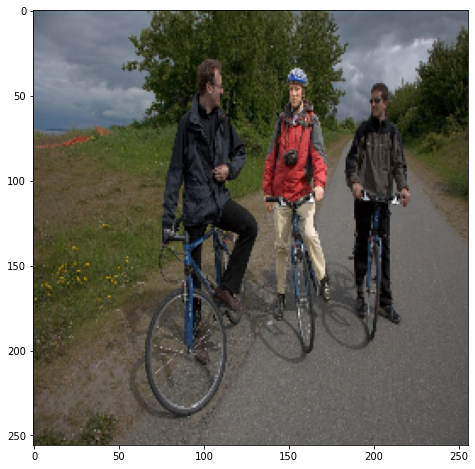

Composite object mask:


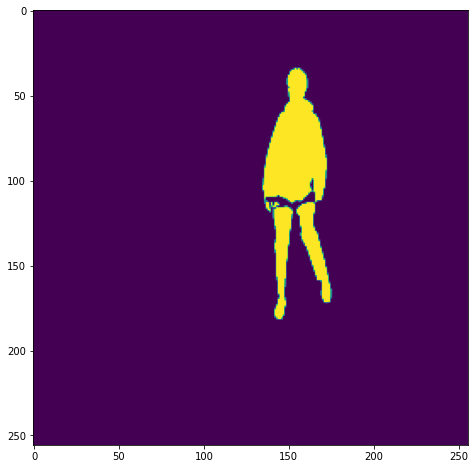

Predicted harmonized image:


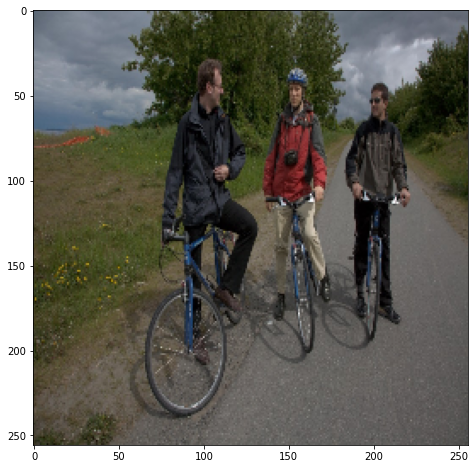

Original image:


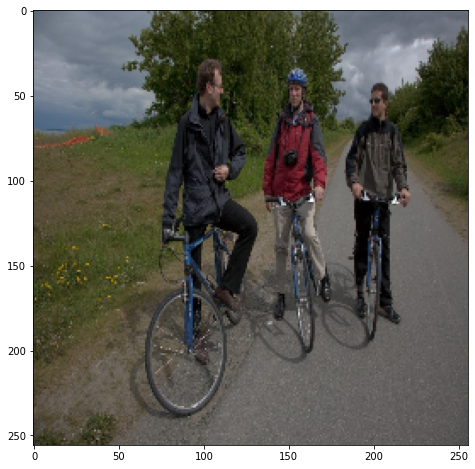

In [15]:
sample_id = 12

sample = dataset.get_sample(sample_id)
sample = dataset.augment_sample(sample)

figsize=(10, 8)
print('Composite image:')
plt.figure(figsize=figsize)
plt.imshow(sample['image'])
plt.show()

print('Composite object mask:')
plt.figure(figsize=figsize)
plt.imshow(sample['object_mask'])
plt.show()

pred = predictor.predict(sample['image'], sample['object_mask']).astype(np.uint8)

print('Predicted harmonized image:')
plt.figure(figsize=figsize)
plt.imshow(pred)
plt.show()

print('Original image:')
plt.figure(figsize=figsize)
plt.imshow(sample['target_image'])
plt.show()

### Make visualization

In [ ]:
import cv2
from pathlib import Path
from tqdm.notebook import trange

output_vis_path = Path('/hdd0/harmonization_exps/visualization/hrnet_dih_001_adobe5k_last/adobe5k')
output_vis_path.mkdir(parents=True, exist_ok=True)

for sample_id in trange(100):
    sample = dataset.get_sample(sample_id)
    sample = dataset.augment_sample(sample)
    
    pred = predictor.predict(sample['image'], sample['object_mask']).astype(np.uint8)
    
    splitter = np.full((pred.shape[0], 25, 3), 255, dtype=np.uint8)
    
    vis_sample = np.concatenate((sample['image'], splitter, pred,
                                 splitter, sample['target_image']), axis=1)
    
    vis_sample = cv2.cvtColor(vis_sample, cv2.COLOR_RGB2BGR)
    cv2.imwrite((output_vis_path / dataset.dataset_samples[sample_id]).as_posix(),
                vis_sample, [cv2.IMWRITE_JPEG_QUALITY, 85])